In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
import copy
x_tmp = copy.deepcopy(x_test[0])

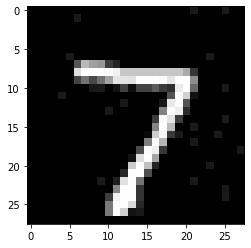

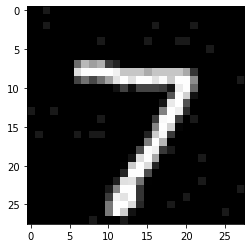

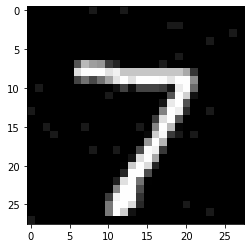

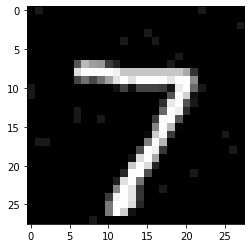

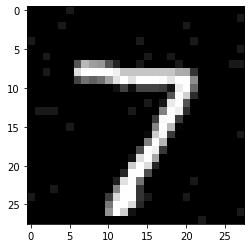

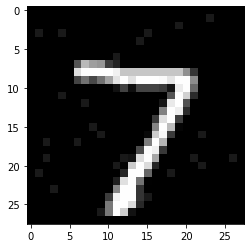

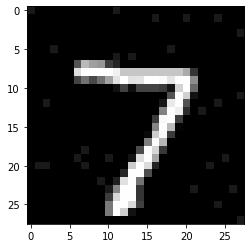

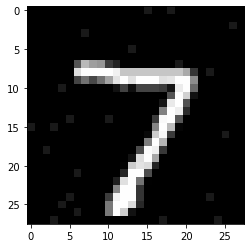

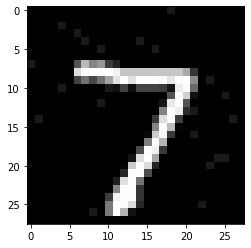

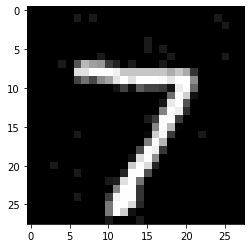

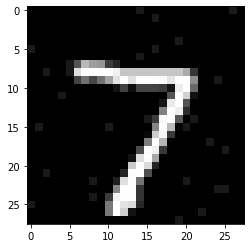

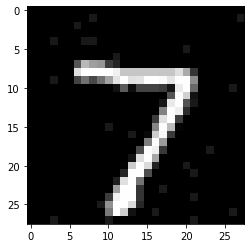

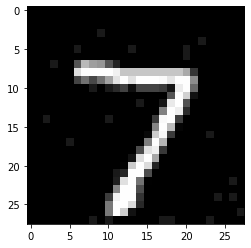

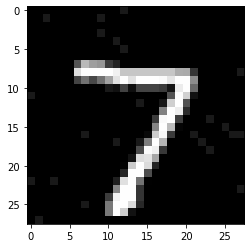

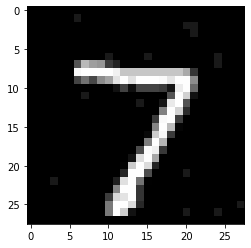

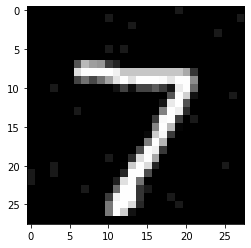

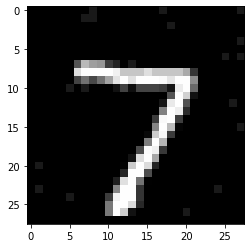

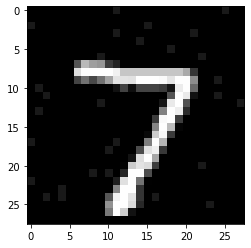

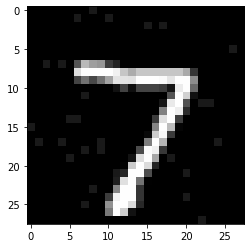

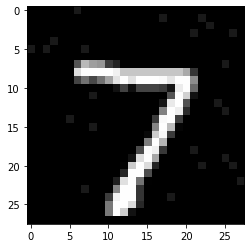

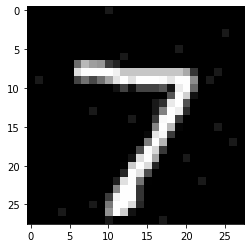

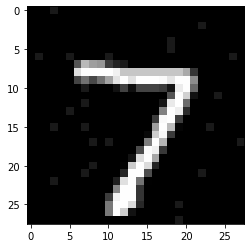

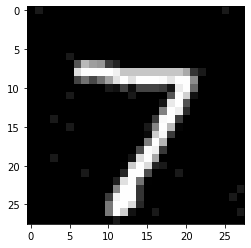

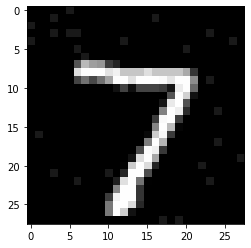

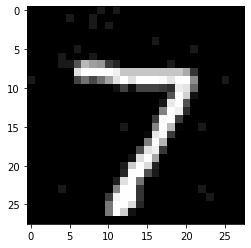

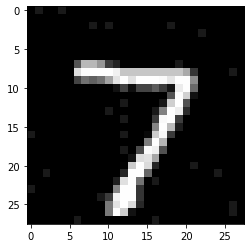

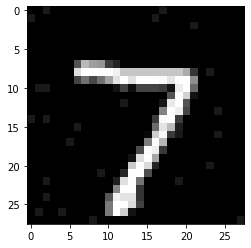

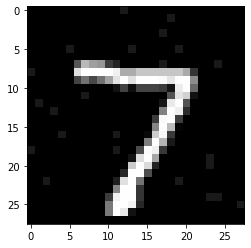

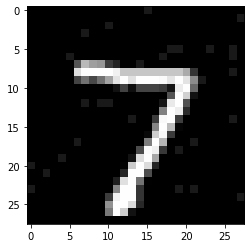

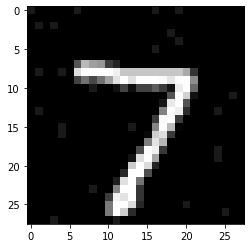

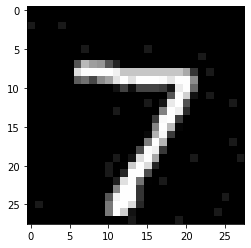

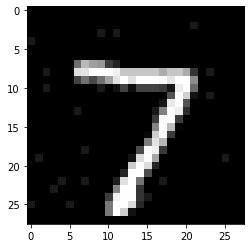

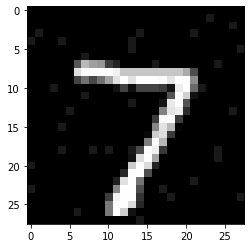

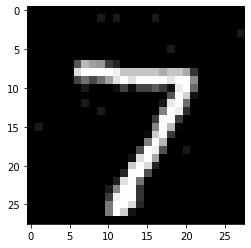

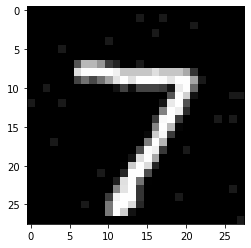

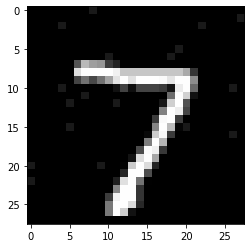

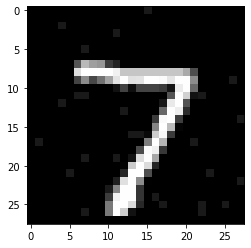

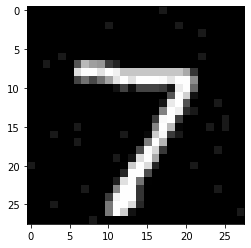

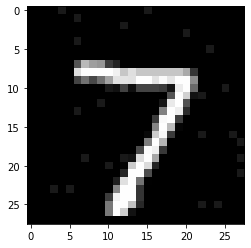

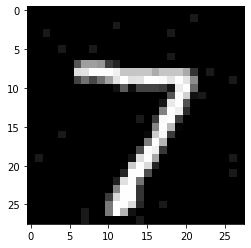

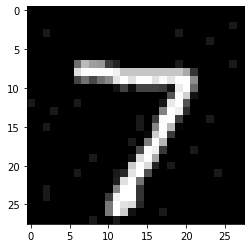

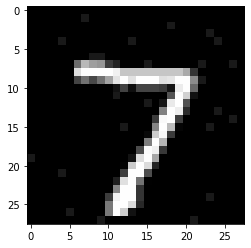

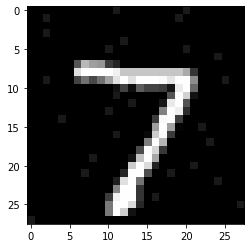

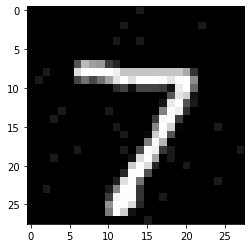

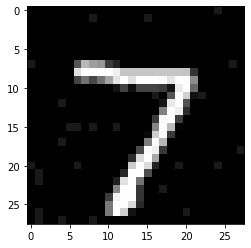

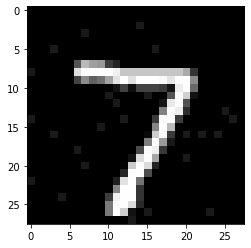

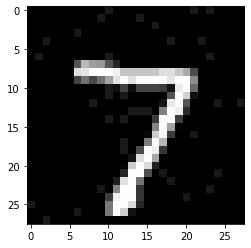

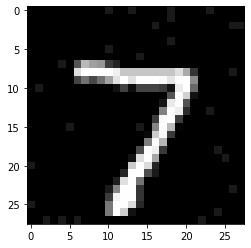

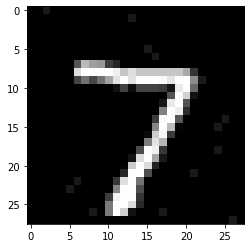

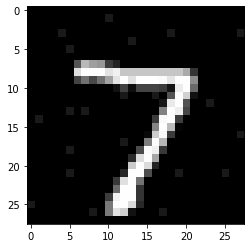

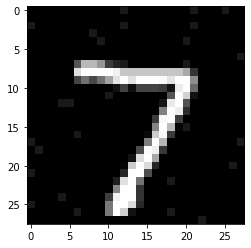

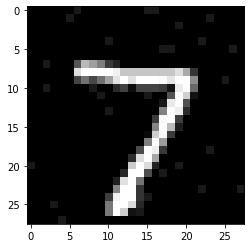

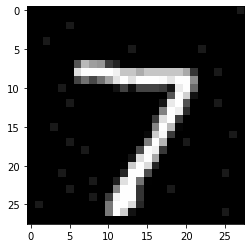

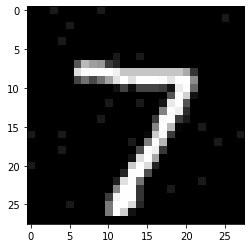

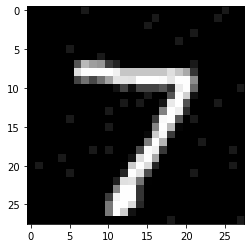

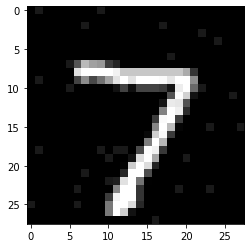

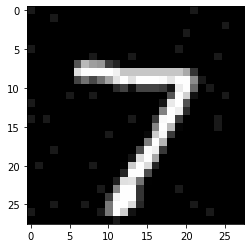

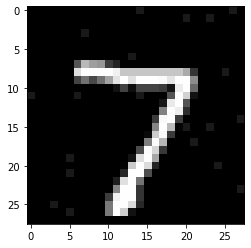

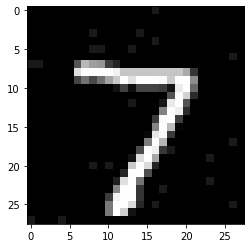

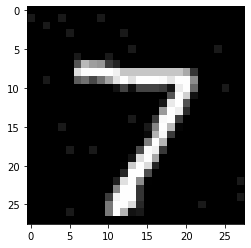

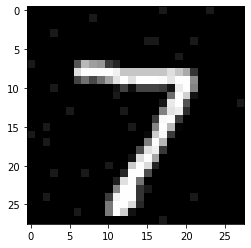

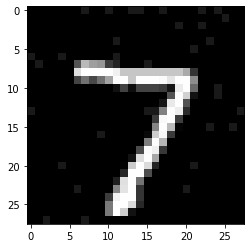

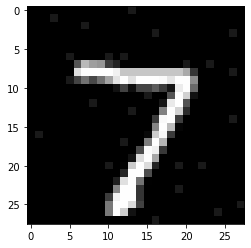

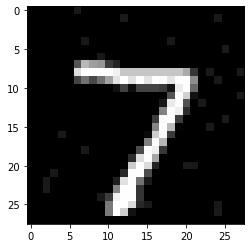

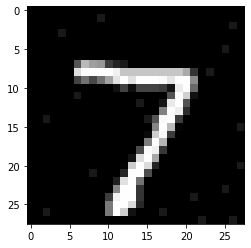

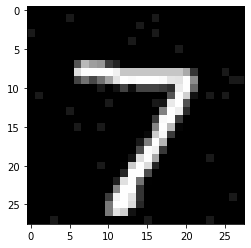

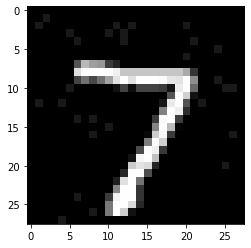

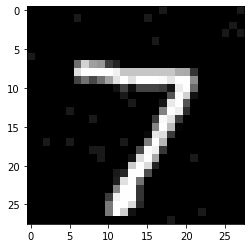

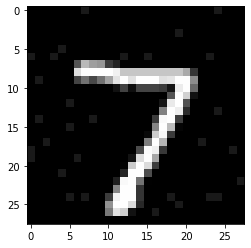

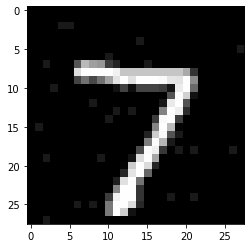

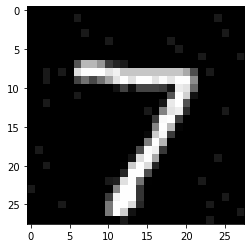

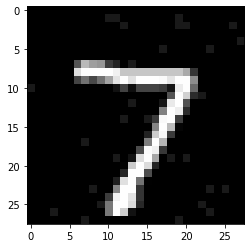

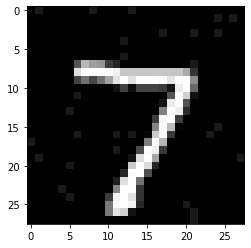

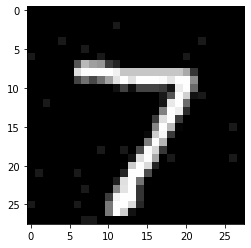

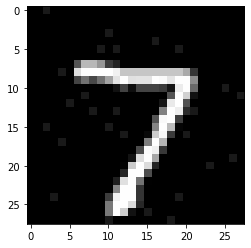

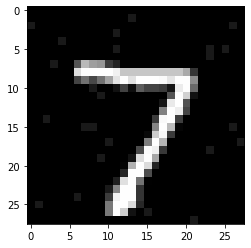

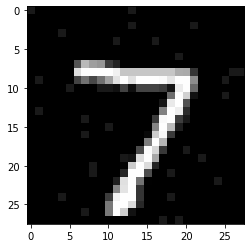

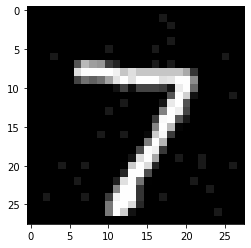

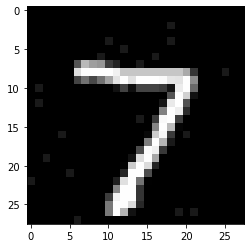

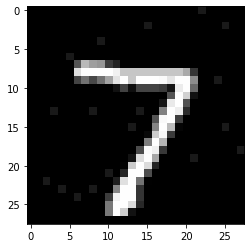

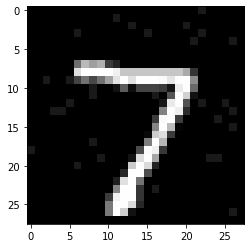

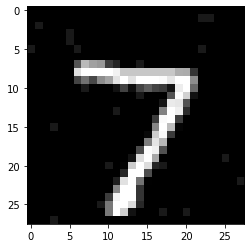

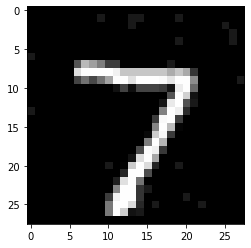

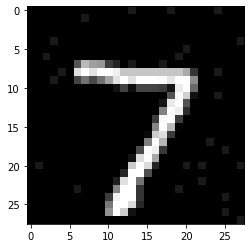

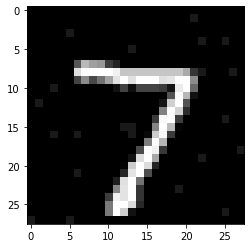

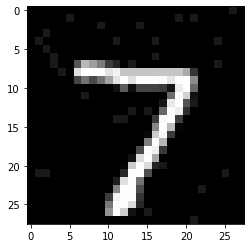

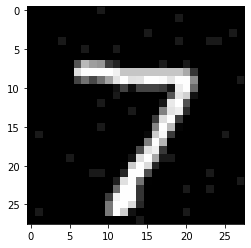

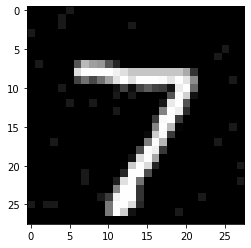

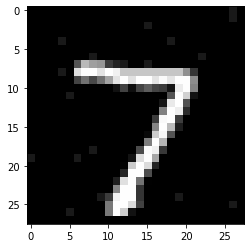

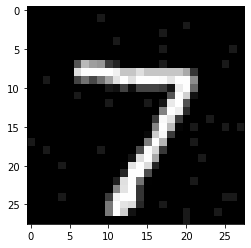

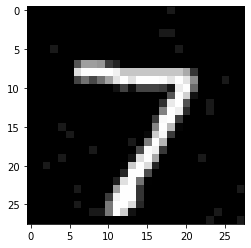

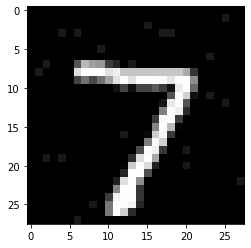

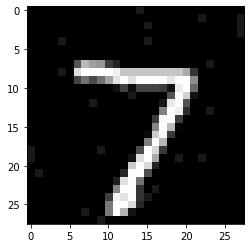

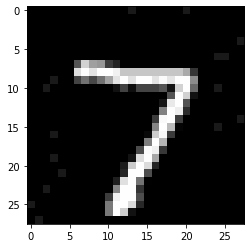

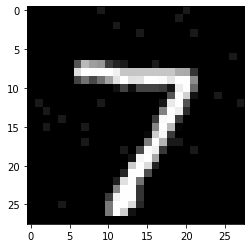

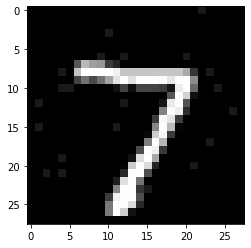

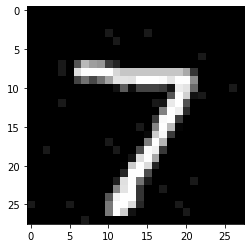

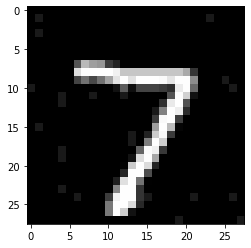

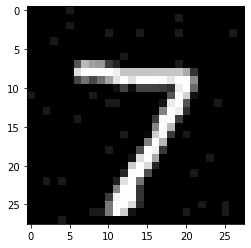

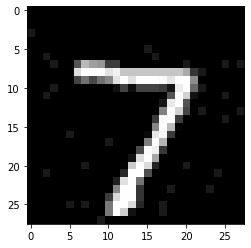

In [4]:
#产生扰动种群
x_des = []
for r in range(100):
    for i in range(28):
        for j in range(28):
            x= random.randint(0,10000)/10000
            if x <= 0.1:
                u = x_tmp[i,j] # 期望值μ
                sig = math.sqrt(0.2) # 标准差δ
                x_ = random.uniform(u - 3*sig, u + 3*sig)
                y_sig = np.exp(-(x_ - u) ** 2 /(2* sig **2))/(math.sqrt(2*math.pi)*sig)
                y_= random.randint(0,10000)/10000
                if y_ <= y_sig:
                    if x_test[0][i,j] <= 127:
                        x_tmp[i,j] += 255*0.1
                    elif x_test[0][i,j] > 127 and x_test[0][i,j] < 229:
                        y = random.randint(0,10000)/10000
                        if y <= 0.5:
                            x_tmp[i,j] += 255*0.1
                        else:
                            x_tmp[i,j] -= 255*0.1
                    elif x_test[0][i,j] >= 229:
                        x_tmp[i,j] -= 255*0.1
    x_t = x_tmp/255-x_test[0]/255
    #x_des.append(np.array (x_t.reshape(1,784)))
    x_des.append(np.array(x_t.reshape(1,784)))
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

In [5]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [6]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [7]:
x_train = x_train / 255
x_test = x_test / 255 

In [8]:
model = load_model('mnist_model.h5')

In [9]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [10]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [11]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        while GENERATION < MAX_GENERATION: 
        #for t in range(5):
            #print(Func(BEST_X))
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i]:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X):
                        BEST_X = U[i, :]
            GENERATION += 1
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            
            
            if Func(BEST_X) <= F:
                print("resume")
                D += 0.5
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        while GENERATION < MAX_GENERATION:
        #for t in range(5):
            #print(Func(BEST_X))
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i]:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X):
                        BEST_X = U[i, :]
            GENERATION += 1
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            
            
            if Dis(BEST_X) <= D:
                print("attack")
                F -= 0.1
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [12]:
MAX_GENERATION = 300  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
F = 0.8   #置信度参数
D = 4.0   #扰动参数
cond = threading.Condition()
atk = Atk(cond, "attack")
re = Re(cond, "resume")

GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
re.start()
atk.start()

#re.join()
#atk.join()
if GENERATION == MAX_GENERATION:
    BEST_F = BEST_X+x_test[0]
    #print(BEST_X_F)
    plt.imshow(BEST_F.reshape(28,28),cmap='gray')
    plt.show()
    #break

attack
最优值： 0.99665725 扰动程度： 0.28805630526720505 代数： 1
最优值： 0.99658525 扰动程度： 0.3997478217062767 代数： 2
最优值： 0.9965373 扰动程度： 0.3386825643983085 代数： 3
最优值： 0.9964916 扰动程度： 0.33654450211457154 代数： 4
最优值： 0.9964104 扰动程度： 0.49798992948710286 代数： 5
最优值： 0.9963728 扰动程度： 0.5078251826651305 代数： 6
最优值： 0.99615854 扰动程度： 0.3898323236245888 代数： 7
最优值： 0.99600273 扰动程度： 0.49419835834213366 代数： 8
最优值： 0.9959448 扰动程度： 0.5273590167184126 代数： 9
最优值： 0.99583995 扰动程度： 0.5356292704849491 代数： 10
最优值： 0.9957943 扰动程度： 0.4946517919255398 代数： 11
最优值： 0.99564964 扰动程度： 0.502579387802834 代数： 12
最优值： 0.99547464 扰动程度： 0.5449787265951187 代数： 13
最优值： 0.9951977 扰动程度： 0.4651807005400968 代数： 14
最优值： 0.9951428 扰动程度： 0.5607578990537644 代数： 15
最优值： 0.9950447 扰动程度： 0.5579517654033628 代数： 16
最优值： 0.99484915 扰动程度： 0.5703315473931885 代数： 17
最优值： 0.9947977 扰动程度： 0.6046786703763397 代数： 18
最优值： 0.99447507 扰动程度： 0.5955147878886855 代数： 19
最优值： 0.9944326 扰动程度： 0.6072045397595128 代数： 20
最优值： 0.9942162 扰动程度： 0.5886743190197862 代数： 21
最优值

最优值： 0.64499575 扰动程度： 8.807436301231922 代数： 174
最优值： 0.641269 扰动程度： 8.656098979737362 代数： 175
最优值： 0.6430473 扰动程度： 8.788039110287725 代数： 176
最优值： 0.6349362 扰动程度： 8.848612101808714 代数： 177
最优值： 0.61803454 扰动程度： 9.11689829469344 代数： 178
最优值： 0.61086565 扰动程度： 9.267778324498673 代数： 179
最优值： 0.61449903 扰动程度： 9.207536073072147 代数： 180
最优值： 0.6064289 扰动程度： 9.299904716518347 代数： 181
最优值： 0.6059049 扰动程度： 9.289624735026193 代数： 182
最优值： 0.60556906 扰动程度： 9.233052069489293 代数： 183
最优值： 0.5972529 扰动程度： 9.292154034087556 代数： 184
resume
最优值： 0.75454473 扰动程度： 6.874924349459915 代数： 185
最优值： 0.7649082 扰动程度： 6.827444981538169 代数： 186
最优值： 0.7654503 扰动程度： 6.823911176084379 代数： 187
最优值： 0.76625854 扰动程度： 6.813322382759148 代数： 188
最优值： 0.79340523 扰动程度： 6.358013530281027 代数： 189
最优值： 0.80011624 扰动程度： 6.223647697385107 代数： 190
最优值： 0.81094986 扰动程度： 6.150304392492049 代数： 191
最优值： 0.8057177 扰动程度： 6.170993845430968 代数： 192
最优值： 0.8184451 扰动程度： 5.9675290653385735 代数： 193
最优值： 0.8175811 扰动程度： 5.9726147957333 代数： 194

In [20]:
BEST_X

array([ 0.00000000e+00,  1.26735148e-01,  1.39035156e-04,  0.00000000e+00,
        2.79439228e-02,  0.00000000e+00,  1.41153872e-01,  0.00000000e+00,
        2.11260062e-02,  2.04846078e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.33830841e-02,
        2.64419425e-02,  1.12253706e-02,  5.94558367e-02,  4.15427195e-02,
        2.14753188e-02,  5.40040314e-06,  1.33133087e-01,  0.00000000e+00,
        6.95938540e-03,  0.00000000e+00,  7.71061238e-03,  1.20979712e-01,
        1.90906238e-04,  0.00000000e+00,  7.79246482e-04,  1.89839565e-03,
        1.17708699e-02,  0.00000000e+00,  0.00000000e+00,  1.46001725e-02,
        0.00000000e+00,  2.45215243e-01,  0.00000000e+00,  2.13271582e-03,
        0.00000000e+00,  1.73050315e-02,  7.14797547e-02,  6.00243751e-03,
        1.26875286e-03,  0.00000000e+00,  1.22684835e-02,  6.27442564e-03,
        0.00000000e+00,  5.24553163e-03,  3.64109150e-03,  0.00000000e+00,
        0.00000000e+00,  

In [21]:
BEST_F

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.09803922, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.09803922, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.09803922,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09803922, 0.        ,
       0.        , 0.        , 0.        , 0.09803922, 0.     

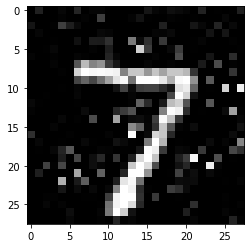

In [22]:
BEST = BEST_X + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [23]:
result=model.predict(BEST_X.reshape(1,784))
result[0]

array([0.03606191, 0.13325453, 0.30351505, 0.14268604, 0.03217717,
       0.18159828, 0.06348677, 0.01640903, 0.07245255, 0.01835869],
      dtype=float32)

In [14]:
# test
count = 0
for i in range(784):
    if BEST_X[i] != 0:
        count+=1
print(count)

448


In [15]:
# test
count = 0
for i in range(784):
    if BEST_X[i] > 0.8:
        count+=1
print(count)

4


In [55]:
V=[1.175,0.8,1.5,1.32,1.912]
for i in range(5):
                    if V[i] > 1:
                        V[i] =1-(V[i]-1)
                       
V = [round(i,3) for i in V]
V

[0.825, 0.8, 0.5, 0.68, 0.088]